In [1]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
from lacbox.io import load_pwr, load_oper
from pathlib import Path
from our_values import *
import pandas as pd
from lacbox.io import load_ctrl_txt
from scipy.optimize import curve_fit
from lacbox.io import ReadHAWC2
from lacbox.test import test_data_path
from lacbox.io import load_stats, load_oper

plt.rcParams.update({'font.family': 'serif', 'font.size':16})
from matplotlib.ticker import FormatStrFormatter



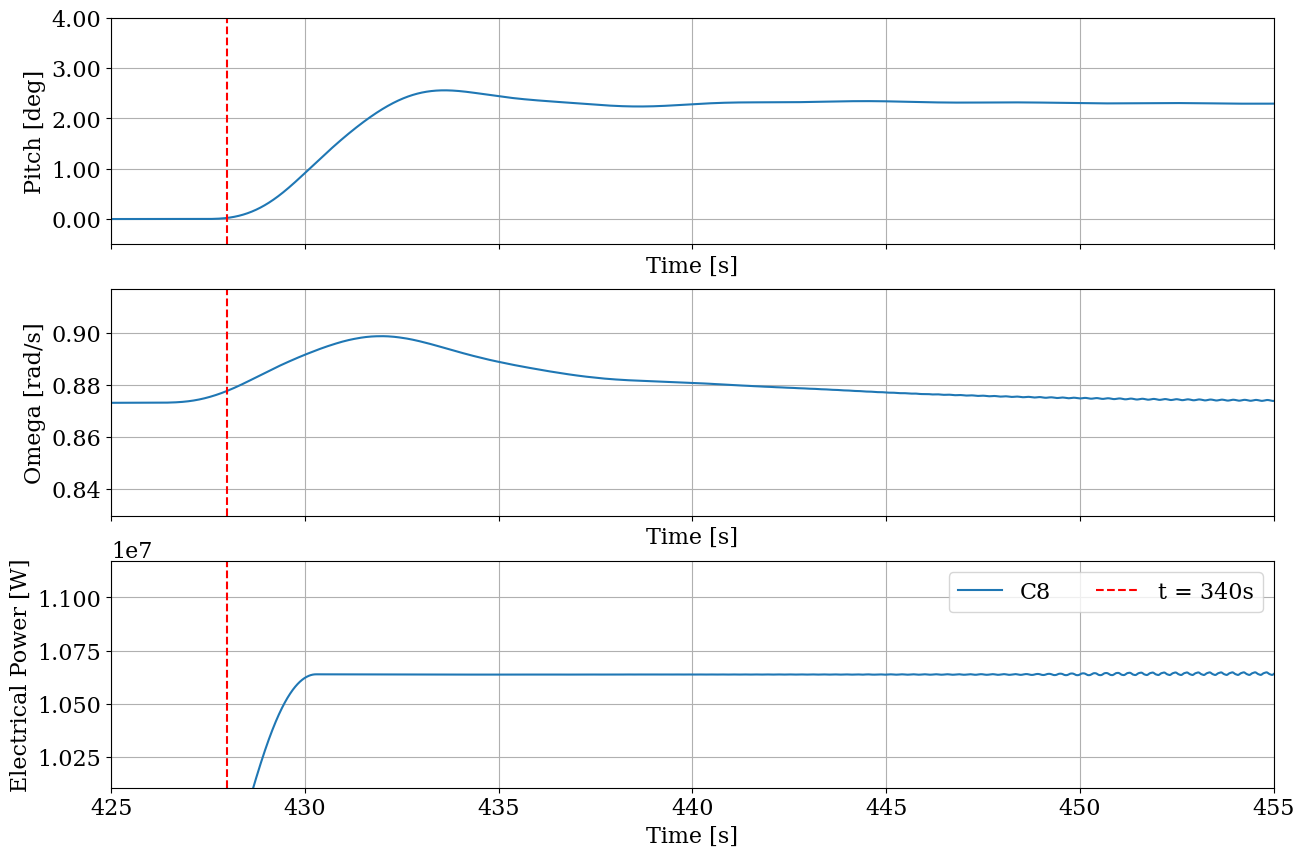

In [2]:
# filter

xmin = 425
xmax = 455
filter_num = 200

def filter(time, y, div):
    n = len(time)
    delta = int(div/2)

    result = np.zeros(n)
    for i in range(delta,n-delta):
        result[i] = np.mean(y[i-delta:i+delta])
    
    for i in range(0,delta):
        result[i] = np.mean(y[0:delta])
    for i in range(n-delta, n):
        result[i] = np.mean(y[n-delta:n])

    return result


# assignemnt 3, best controller
# it's a nice plot come on

vertical_line_time = 428
horizontal_line_wsp = V_RATED_Y
fontSize = 14
xmin = 425
xmax = 455
fig, (ax_pitch, ax_omega, ax_power) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

k=8
# Filename for each iteration
fname = f'our_design/res/Group1_redesign_hawc2s_step_C{k}.hdf5'
h2res = ReadHAWC2(fname)

# Retrieve channel information
names, units, desc = h2res.chaninfo

# Extract indices for time, WSP, Omega, pitch, and power
idx_Time = np.where(['Time [s]' in name for name in names])[0]
idx_Omega = np.where(['Omega' in name for name in names])[0]
idx_pitch = np.where(['bea2 angle' in name for name in names])[0]
idx_power = np.where(['DLL inp   2:   2' in name for name in names])[0]

# Plot Pitch
ax_pitch.plot(h2res.t, filter(h2res.t, h2res.data[:, idx_pitch[0]], filter_num), label=f'Pitch (C{k})')

# Plot Omega
ax_omega.plot(h2res.t, filter(h2res.t, h2res.data[:, idx_Omega], filter_num), label=f'Omega (C{k})')

# Plot Power
ax_power.plot(h2res.t, filter(h2res.t, h2res.data[:, idx_power], filter_num), label=f'C{k}')



ax_pitch.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_omega.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')
ax_power.axvline(x=vertical_line_time, color='red', linestyle='--', label='t = 340s')

# Set labels and titles for Pitch plot
ax_pitch.set_xlabel('Time [s]')
ax_pitch.set_ylabel('Pitch [deg]')
ax_pitch.set(xlim=[xmin, xmax])
ax_pitch.set(ylim=[-0.5, 4])
ax_pitch.yaxis.set_major_formatter(FormatStrFormatter('%3.2f'))  # Set y-ticks to 1 decimal
ax_pitch.grid()
#ax_pitch.legend(ncol=2)

# Set labels and titles for Omega plot
ax_omega.set_xlabel('Time [s]')
ax_omega.set_ylabel('Omega [rad/s]')
ax_omega.set(xlim=[xmin, xmax])
ax_omega.set(ylim=[OMEGA_MAX*np.pi/30*0.95, OMEGA_MAX*np.pi/30*1.05])
ax_omega.grid()
#ax_omega.legend(ncol=2)

# Set labels and titles for Power plot
ax_power.set_xlabel('Time [s]')
ax_power.set_ylabel('Electrical Power [W]')
ax_power.set(xlim=[xmin, xmax])
ax_power.set(ylim=[POWER_MAX*0.95, POWER_MAX*1.05])
ax_power.grid()
ax_power.legend(ncol=2)

# Save each figure to a file
#fig_omega.savefig('omega_plot_17.pdf')  # Save Omega plot
#fig_power.savefig('power_plot_17.pdf')  # Save Power plot
#fig_wsp.savefig('wsp_plot_17.pdf')      # Save WSP plot
#fig_pitch.savefig('pitch_plot_17.png')  # Save Pitch plot

# Show all plots
#fig.savefig('plots/3_3_14.pdf', format='pdf',bbox_inches='tight')
plt.show()




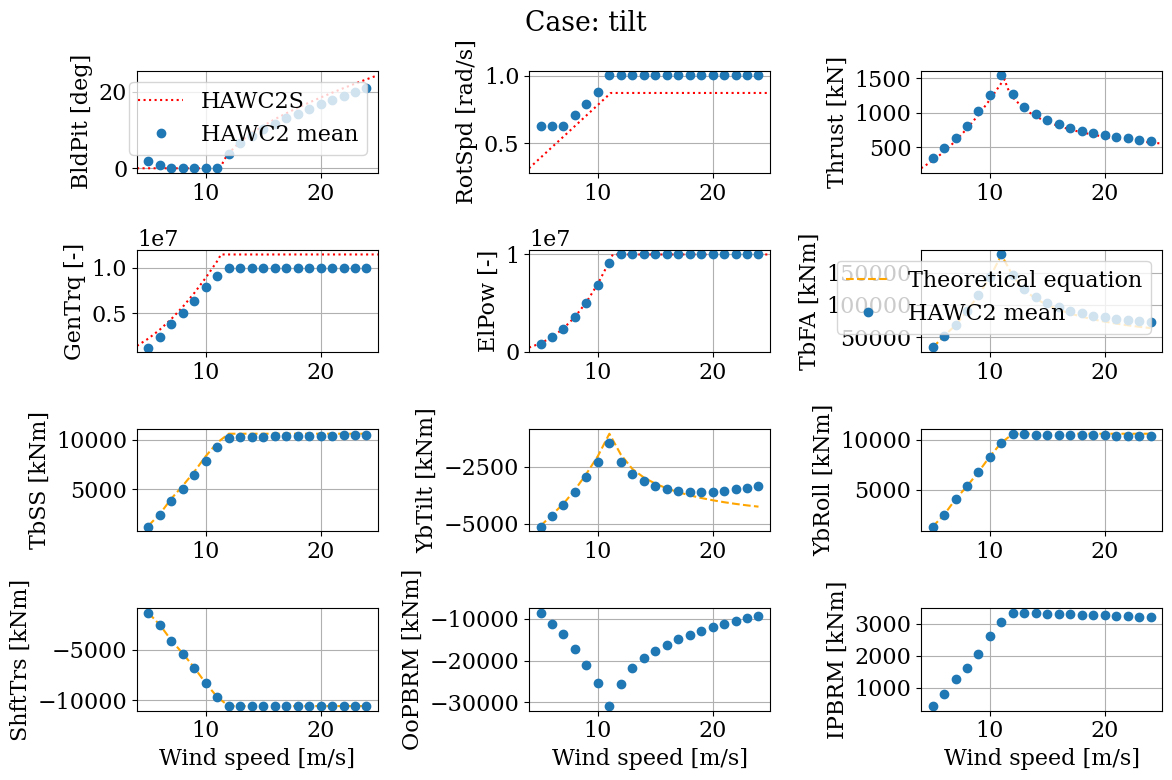

In [3]:
# code from plot_steady.py

# -*- coding: utf-8 -*-

"""Compare mean value of steady simulations in HAWC2 (blue dots) to "theory" (lines).

For the operational parameters (i.e., pitch, rotor speed, etc.), the "theoretical" values
are the corresponding values in a .pwr file.

For the load channels of interest, the theoretical lines are calculated according to the
theoretical equations we derived for each load channel, as a function of thrust/torque/
gravity moment.

YOUR TASK! Add the lines that calculate the theory, as prompted by the slides.
"""

# analysis settings
HAWC2S_PATH = 'our_design/data/Group1_redesign_flex.opt'  # path to .pwr or .opt file
STATS_PATH = 'our_design/res/dtu_10mw_steady_stats.csv'  # path to mean steady stats, CHANGE!!!!
SUBFOLDER = 'tilt'  # which subfolder to plot: tilt, notilt, notiltrigid, notiltnodragrigid

# turbine constants
GENEFF = 0.94  # generator/gearbox efficienty [%]
FG_TIMES_DY = 6250  # yaw-bearing pitch moment due to gravity [kNm]
if 'notilt' in SUBFOLDER:
    DZ_YB = 2.75  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
else:
    DZ_YB = 2.75 + 7.1*np.sin(5*np.pi/180)  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# load the HAWC2 data from the stats file. Isolate the simulations with no tilt.
df, wsps = load_stats(STATS_PATH, subfolder=SUBFOLDER, statstype='steady')

# load/calc. the stuff we need from the HAWC2S opt/pwr file for the operational data comparisons
opt_dict = load_oper(HAWC2S_PATH)
h2s_u, h2s_pitch, h2s_rotspd, = opt_dict['ws_ms'], opt_dict['pitch_deg'], opt_dict['rotor_speed_rpm']
h2s_paero, h2s_thrust = opt_dict['power_kw'], opt_dict['thrust_kn']
h2s_aerotrq = h2s_paero / (h2s_rotspd * np.pi / 30)

# get hawc2 thrust and aerodynamic torque for theoretical calculations
h2_thrust = df.filter_channel('Thrust', CHAN_DESCS)['mean']
h2_aero_trq = df.filter_channel('GenTrq', CHAN_DESCS)['mean'] / GENEFF * 1e-3  # aerodynamic torque [kNm]

# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']
    HAWC2val = chan_df['mean']

    match chan_id:
        # ===========================================================================
        # PART 1. HAWC2 operational data versus HAWC2S opt file.
        case 'BldPit':  # pitch angle
            u_theory = h2s_u
            theory = h2s_pitch
        case 'RotSpd':  # rotor speed
            u_theory = h2s_u
            theory = h2s_rotspd*np.pi/30
        case 'Thrust':  # thrust
            u_theory = h2s_u
            theory = h2s_thrust
        case 'GenTrq': # generator torque
            u_theory = h2s_u
            theory = h2s_aerotrq*GENEFF*1e3
        case 'ElPow':  # electrical power
            u_theory = h2s_u
            theory = h2s_paero*GENEFF*1e3

        # ===========================================================================
        # PART 2. HAWC2 loads versus theory calculated using HAWC2 thrust/torque.
        case 'TbFA':  # tower-base fore-aft
            u_theory = h2_wind
            theory = h2_thrust * DZ_TB - FG_TIMES_DY
        case 'TbSS':  # tower-base side-side
            u_theory = h2_wind
            theory = h2_aero_trq
        case 'YbTilt':  # yaw bearing tilt
            u_theory = h2_wind
            theory = h2_thrust * DZ_YB - FG_TIMES_DY     # ????
        case 'YbRoll':  # yaw bearing roll
            u_theory = h2_wind
            theory = h2_aero_trq
        case 'ShftTrs':  # shaft torsion
            u_theory = h2_wind
            theory = -h2_aero_trq

        # other values have no theory
        case other:
            u_theory = h2_wind
            theory = np.nan * np.ones_like(u_theory)

    # sort both the theory and the hawc2 by increasing wind speed (convert to numpy arrays first)
    u_theory, theory = np.array(u_theory), np.array(theory)
    h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val)
    i_theory = np.argsort(u_theory)
    i_h2 = np.argsort(h2_wind)

    # define legend label for the "theoretical" line
    if np.nan in theory:
        theory_label = None
    elif np.array_equal(u_theory, h2s_u):
        theory_label = 'HAWC2S'
        linestyle, color = ':', 'r'
    else:
        theory_label = 'Theoretical equation'
        linestyle, color = '--', '#ffa500'

    # plot the results
    ax = axs.flatten()[iplot]
    ax.plot(u_theory[i_theory], theory[i_theory], linestyle=linestyle, c=color, label=theory_label)  # theoretical line
    ax.plot(h2_wind[i_h2], HAWC2val[i_h2], 'o', label='HAWC2 mean')  # HAWC2 steady results
    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df.units.iloc[0]}]', xlim=[4, 25])

axs[0, 0].legend()
axs[1, 2].legend()
fig.suptitle(f'Case: {SUBFOLDER}')
fig.tight_layout()

plt.show()
